## Setup

In [1]:
%matplotlib inline

In [2]:
!pip install aif360
!pip install adversarial-robustness-toolbox
!pip install shap
!pip install BlackBoxAuditing
# preventing future warnings
!pip install 'aif360[Reductions]'
!pip install 'aif360[inFairness]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 38.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394754 sha256=f2838fe7e75fe067b9598d8dbbe8e23a9bb561176d7adce03ab34d398e1bffa7
  Stored in directory: /root/.cache/pip/wheels/c0/4f/b1/80e1b0790df07536470758fe0a4f9ff8fa942fd9fe30bbb192
Successfully built BlackBoxAuditing
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.4/835.4 kB 35.4 MB/s eta 0:00:00


In [3]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [4]:
from aif360.datasets import StandardDataset
# StandardDataset??

In [14]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
%cd "/content/drive/MyDrive/Senior Design Project/mia-privacy-fairness-grade"

/content/drive/MyDrive/Senior Design Project/mia-privacy-fairness-grade


In [7]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGRMitigator, PRMitigator, CPPMitigator, ROMitigator
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias

/usr/local/lib/python3.10/dist-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/usr/local/lib/python3.10/dist-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_discounted

## Arguments & Initializations

In [8]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade ")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")

_StoreAction(option_strings=['-o', '--os'], dest='os', nargs=None, const=None, default=2, type=None, choices=None, required=False, help='oversample mode: 1: privi unfav 2: unpriv fav', metavar=None)

In [9]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [10]:
DATASET = "grade"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])

In [11]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2}

In [12]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False
else:
    SCALER = False
DISPLAY = False
THRESH_ARR = 0.5

# loop ten times
N = 3

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list)
transf_mia_metrics = defaultdict(list)

reweigh_metrics = defaultdict(list)
reweigh_mia_metrics = defaultdict(list)

dir_metrics = defaultdict(list)
dir_mia_metrics = defaultdict(list)

egr_metrics = defaultdict(list)
egr_mia_metrics = defaultdict(list)


pr_orig_metrics = defaultdict(list)
cpp_metrics = defaultdict(list)
ro_metrics = defaultdict(list)

## Loading & Splitting Dataset

In [13]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

# training data split ratio
p = 0.5

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-da1add83a5ac>", line 3, in <cell line: 3>
    dataset_orig = dataset_builder.load_data()
  File "/content/drive/MyDrive/Senior Design Project/mia-privacy-fairness-grade/data_utils.py", line 176, in load_data
    df = pd.read_csv(dataset_loc, sep=",")
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.

AttributeError: 'str' object has no attribute 'coloumns'

In [ ]:
dataset_orig.features.shape

(30488, 57)

In [ ]:
privileged_groups

[{'age': 1}]

In [ ]:
# split dataset into train, validation, and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
dataset_orig_val = dataset_orig_test
print(dataset_orig_train.features)

[[  1.  78.   9. ...   0.   1.   0.]
 [  1. 169.   1. ...   0.   1.   0.]
 [  1. 159.   2. ...   0.   1.   0.]
 ...
 [  1.  31.  19. ...   0.   1.   0.]
 [  0. 162.   2. ...   1.   0.   0.]
 [  1. 228.   1. ...   0.   1.   0.]]


In [ ]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig_train.favorable_label
uf_label = dataset_orig_train.unfavorable_label
feature_names = dataset_orig_train.feature_names

# introduce label or selection biases, assuming the original data is fair
if BIAS_TYPE == 'label':
    dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
elif BIAS_TYPE == 'selection':
    dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
else:
    print('no bias type specified')

no bias type specified


In [ ]:
dataset_orig_train

               instance weights            features                           \
                                protected attribute                            
                                                age duration campaign  pdays   
instance names                                                                 
5038                        1.0                 1.0     78.0      9.0  999.0   
25754                       1.0                 1.0    169.0      1.0  999.0   
19635                       1.0                 1.0    159.0      2.0  999.0   
6291                        1.0                 1.0    151.0      5.0  999.0   
38193                       1.0                 1.0     96.0      1.0  999.0   
...                         ...                 ...      ...      ...    ...   
10768                       1.0                 1.0    169.0      4.0  999.0   
11325                       1.0                 1.0    149.0      3.0  999.0   
14414                       1.0         

In [ ]:
dataset_orig_train?

## Run Mitigating Algorithms

In [ ]:
# run mitigating algorithms
for i in range(N):
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print("#### Train dataset's features are as below:")
    print(dataset_orig_train.features)

    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig_train.favorable_label
    uf_label = dataset_orig_train.unfavorable_label
    feature_names = dataset_orig_train.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False))
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True)
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False)
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER)

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, OS_MODE, SCALER)

    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER)

    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # egr mitigator, in-processing
    egr_metrics, egr_mia_metrics = test_cases.run_egr(dataset_orig_train, dataset_orig_val, dataset_orig_test, egr_metrics, egr_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups,THRESH_ARR, DISPLAY, SCALER)
    # egr gave error so I replaced it with reweigh
#     egr_metrics, egr_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, egr_metrics, egr_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

    # cpp mitigator
    cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    # ro mitigator
    # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

    if (BASELINE == 'lr'):
        pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER)

#### Train dataset's features are as below:
[[  1. 138.   4. ...   1.   0.   0.]
 [  1.  91.   4. ...   0.   1.   0.]
 [  1. 192.   2. ...   1.   0.   0.]
 ...
 [  1.  41.   2. ...   0.   1.   0.]
 [  1. 378.   3. ...   0.   1.   0.]
 [  1.  94.   1. ...   0.   1.   0.]]
no bias type specified
#### Training Dataset shape
(15244, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'age': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job=admin.', 'job=blue-collar', 'job=entrepreneur', 'job=housemaid', 'job=management', 'job=retired', 'job=self-employed', 'job=services', 'job=student', 'job=technician', 'job=unemployed', 'marital=divorced', 'marital=married', 'marital=single', 'educatio

Protected_attr_val, label, 0.0 0.0
Protected_attr_val, label, 0.0 1.0
Protected_attr_val, label, 1.0 0.0
Protected_attr_val, label, 1.0 1.0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.05
  Positive predictive value: 0.58
  Optimal thershold: -0.9473813189441862
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13356, Test = 13273
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.03
  Positive predictive value: 0.56
  Optimal thershold: -0.7621400520468967
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1888, Test = 1971
  AUC: 0.63
  Privacy Risk: 0.60
  Accuracy: 0.59
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.20
  Positive predictive value:

Protected_attr_val, label, 1.0 1.0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.04
  Positive predictive value: 0.59
  Optimal thershold: -0.587786664902119
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13356, Test = 13273
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.03
  Positive predictive value: 0.58
  Optimal thershold: -0.3184537311185346
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1888, Test = 1971
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.57
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.25
  Attacker advantage: 0.15
  Positive predictive value: 0.60
  Optimal thershold: -1.6007042324653458
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of

Protected_attr_val, label, 1.0 1.0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.50
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.10
  Positive predictive value: 0.53
  Optimal thershold: -0.6539264674066639
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13356, Test = 13273
  AUC: 0.47
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.10
  Positive predictive value: 0.53
  Optimal thershold: -0.6143663027068311
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1888, Test = 1971
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.57
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.28
  Attacker advantage: 0.15
  Positive predictive value: 0.66
  Optimal thershold: -1.3173014896329391
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size o

Protected_attr_val, label, 1.0 1.0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.05
  Positive predictive value: 0.58
  Optimal thershold: -0.6821006187970099
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13356, Test = 13273
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.03
  Positive predictive value: 0.56
  Optimal thershold: -0.6687664236174242
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1888, Test = 1971
  AUC: 0.64
  Privacy Risk: 0.61
  Accuracy: 0.60
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.21
  Positive predictive value: 0.63
  Optimal thershold: -1.06717510727512
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

y_val_pred_prob:  [[0.]
 [0.]
 [0.]
 ...
 [1.]
 [0.]
 [0.]]
Accuracy for threshold: 0.01  is: 0.8913014956704277
Balanced accuracy is:  0.8198557567360647
Accuracy for threshold: 0.02  is: 0.8913014956704277
Balanced accuracy is:  0.8198557567360647
Accuracy for threshold: 0.03  is: 0.8913014956704277
Balanced accuracy is:  0.8198557567360647
Accuracy for threshold: 0.04  is: 0.8913014956704277
Balanced accuracy is:  0.8198557567360647
Accuracy for threshold: 0.05  is: 0.8913014956704277
Balanced accuracy is:  0.8198557567360647
Accuracy for threshold: 0.060000000000000005  is: 0.8913014956704277
Balanced accuracy is:  0.8198557567360647
Accuracy for threshold: 0.06999999999999999  is: 0.8913014956704277
Balanced accuracy is:  0.8198557567360647
Accuracy for threshold: 0.08  is: 0.8913014956704277
Balanced accuracy is:  0.8198557567360647
Accuracy for threshold: 0.09  is: 0.8934662818157963
Balanced accuracy is:  0.7947459208779697
Accuracy for threshold: 0.09999999999999999  is: 0.893

Accuracy for threshold: 0.29000000000000004  is: 0.8865783258987142
Balanced accuracy is:  0.7923025778405275
Accuracy for threshold: 0.3  is: 0.8871687221201784
Balanced accuracy is:  0.7846493205193379
Accuracy for threshold: 0.31  is: 0.8871687221201784
Balanced accuracy is:  0.7846493205193379
Accuracy for threshold: 0.32  is: 0.8871687221201784
Balanced accuracy is:  0.7846493205193379
Accuracy for threshold: 0.33  is: 0.8869719233796903
Balanced accuracy is:  0.7817282067412882
Accuracy for threshold: 0.34  is: 0.887890317501968
Balanced accuracy is:  0.7764233804846687
Accuracy for threshold: 0.35000000000000003  is: 0.887890317501968
Balanced accuracy is:  0.7764233804846687
Accuracy for threshold: 0.36000000000000004  is: 0.887890317501968
Balanced accuracy is:  0.7764233804846687
Accuracy for threshold: 0.37  is: 0.887890317501968
Balanced accuracy is:  0.7764233804846687
Accuracy for threshold: 0.38  is: 0.8884151141432695
Balanced accuracy is:  0.7752126890159707
Accuracy f

Accuracy for threshold: 0.01  is: 0.7432432432432432
Balanced accuracy is:  0.799134905723258
Accuracy for threshold: 0.02  is: 0.7885725531356599
Balanced accuracy is:  0.8176316780669024
Accuracy for threshold: 0.03  is: 0.8194699553922855
Balanced accuracy is:  0.831473092174018
Accuracy for threshold: 0.04  is: 0.8245211230648124
Balanced accuracy is:  0.8323389567369546
Accuracy for threshold: 0.05  is: 0.8248491209656258
Balanced accuracy is:  0.8307299231977503
Accuracy for threshold: 0.060000000000000005  is: 0.8248491209656258
Balanced accuracy is:  0.8307299231977503
Accuracy for threshold: 0.06999999999999999  is: 0.8476121752820782
Balanced accuracy is:  0.8320625969145794
Accuracy for threshold: 0.08  is: 0.8476121752820782
Balanced accuracy is:  0.8320625969145794
Accuracy for threshold: 0.09  is: 0.8604696929939648
Balanced accuracy is:  0.8331233910450615
Accuracy for threshold: 0.09999999999999999  is: 0.8604696929939648
Balanced accuracy is:  0.8331233910450615
Accura

origin, transf:  15244 29656
after transf priv:  0.12523603992446722
after transf unpriv:  0.12523603992446722
Difference in mean outcomes between unprivileged and privileged groups = 0.000000
[INFO]: training decision tree
Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     25942
         1.0       0.89      0.74      0.80      3714

    accuracy                           0.96     29656
   macro avg       0.93      0.86      0.89     29656
weighted avg       0.95      0.96      0.95     29656

Train accuracy:  0.9552198543296466
Validating Original ...
Accuracy for threshold: 0.01  is: 0.7314353188139596
Balanced accuracy is:  0.8006950496693115
Accuracy for threshold: 0.02  is: 0.7920493308842823
Balanced accuracy is:  0.8256819548040077
Accuracy for threshold: 0.03  is: 0.7925741275255839
Balanced accuracy is:  0.822613464728438
Accuracy for threshold: 0.04  is: 0.7959197061138809
Bal

[INFO]: training decision tree
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     13293
         1.0       0.78      0.68      0.73      1951

    accuracy                           0.93     15244
   macro avg       0.87      0.83      0.85     15244
weighted avg       0.93      0.93      0.93     15244

Train accuracy:  0.9349252164786145
Validating Original ...
Accuracy for threshold: 0.01  is: 0.7419312516399895
Balanced accuracy is:  0.7974868076699126
Accuracy for threshold: 0.02  is: 0.7951325111519286
Balanced accuracy is:  0.8200335561818454
Accuracy for threshold: 0.03  is: 0.8230123327210705
Balanced accuracy is:  0.8332731252491641
Accuracy for threshold: 0.04  is: 0.8230123327210705
Balanced accuracy is:  0.8332731252491641
Accuracy for threshold: 0.05  is: 0.8230123327210705
Balanced accuracy is:  0.8332731252491641
Accuracy for threshold: 0.060000000000000005  is: 0.82

####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13293
         1.0       0.80      0.71      0.75      1951

    accuracy                           0.94     15244
   macro avg       0.88      0.84      0.86     15244
weighted avg       0.94      0.94      0.94     15244

Train accuracy:  0.9402387824717922
Validating Original ...
Accuracy for threshold: 0.01  is: 0.7415376541590134
Balanced accuracy is:  0.7963636046375631
Accuracy for threshold: 0.02  is: 0.7889661506166361
Balanced accuracy is:  0.8140390789766575
Accuracy for threshold: 0.03  is: 0.8226187352400944
Balanced accuracy is:  0.8272095580883824
Accuracy for threshold: 0.04  is: 0.8226187352400944
Balanced accuracy is:  0.8272095580883824
Accuracy for threshold: 0.05  is: 0.8226187352400944
Balanced accuracy is:  0.8272095580883824
Accuracy for threshold: 0.060000000000000005  is: 0.8226187352400944
Balanced accurac

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

y_val_pred_prob:  [[1.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
Accuracy for threshold: 0.01  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.02  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.03  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.04  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.05  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.060000000000000005  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.06999999999999999  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.08  is: 0.8949094725793755
Balanced accuracy is:  0.7151504447538165
Accuracy for threshold: 0.09  is: 0.8949094725793755
Balanced accuracy is:  0.7151504447538165
Accuracy for threshold: 0.09999999999999999  is: 0.894

Accuracy for threshold: 0.46  is: 0.895434269220677
Balanced accuracy is:  0.7347627172678672
Accuracy for threshold: 0.47000000000000003  is: 0.895434269220677
Balanced accuracy is:  0.7347627172678672
Accuracy for threshold: 0.48000000000000004  is: 0.895434269220677
Balanced accuracy is:  0.7347627172678672
Accuracy for threshold: 0.49  is: 0.895434269220677
Balanced accuracy is:  0.7347627172678672
Accuracy for threshold: 0.5  is: 0.8959590658619785
Balanced accuracy is:  0.7330415992273244
Best thresh:  0.09
Best balanced accuracy: 0.7330
Corresponding 1-min(DI, 1/DI) value: 0.5426
Corresponding average odds difference value: 0.0161
Corresponding statistical parity difference value: 0.0888
Corresponding equal opportunity difference value: -0.0217
Corresponding Theil index value: 0.0786
Corresponding false positive_rate for privileged: 0.0483
Corresponding false negative_rate for privileged: 0.4831
Corresponding false positive_rate for unpribileged: 0.1020
Corresponding false negat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


Best balanced accuracy: 0.5119
Corresponding 1-min(DI, 1/DI) value: 0.0000
Corresponding average odds difference value: 0.2983
Corresponding statistical parity difference value: 0.1987
Corresponding equal opportunity difference value: 0.4857
Corresponding Theil index value: 0.1310
Corresponding false positive_rate for privileged: 0.0000
Corresponding false negative_rate for privileged: 1.0000
Corresponding false positive_rate for unpribileged: 0.1108
Corresponding false negative_rate for unprivileged: 0.5143
#### Train dataset's features are as below:
[[  1. 118.   3. ...   0.   1.   0.]
 [  1.  78.   1. ...   0.   1.   0.]
 [  0.  93.   2. ...   0.   1.   0.]
 ...
 [  1.  89.   1. ...   0.   1.   0.]
 [  1. 201.   5. ...   0.   1.   0.]
 [  0. 109.   2. ...   0.   1.   0.]]
no bias type specified
#### Training Dataset shape
(15244, 57)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['age']
#### Privileged and unprivileged protected groups
[{'age': 1}] [{'

Protected_attr_val, label, 0.0 0.0
Protected_attr_val, label, 0.0 1.0
Protected_attr_val, label, 1.0 0.0
Protected_attr_val, label, 1.0 1.0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.04
  Positive predictive value: 0.59
  Optimal thershold: -0.8020727623822678
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13293, Test = 13336
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.03
  Positive predictive value: 0.57
  Optimal thershold: -0.5465437063680699
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1951, Test = 1908
  AUC: 0.63
  Privacy Risk: 0.59
  Accuracy: 0.60
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.19
  Positive predictive value:

Protected_attr_val, label, 1.0 1.0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.04
  Positive predictive value: 0.60
  Optimal thershold: -0.8815477834302822
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13293, Test = 13336
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.98
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.02
  Positive predictive value: 0.57
  Optimal thershold: -0.8472978603872036
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1951, Test = 1908
  AUC: 0.62
  Privacy Risk: 0.58
  Accuracy: 0.59
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.17
  Positive predictive value: 0.65
  Optimal thershold: -0.6567795363890705
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size o

Protected_attr_val, label, 0.0 0.0
Protected_attr_val, label, 0.0 1.0
Protected_attr_val, label, 1.0 0.0
Protected_attr_val, label, 1.0 1.0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.04
  Positive predictive value: 0.57
  Optimal thershold: -0.49441259412466054
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13293, Test = 13336
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.03
  Positive predictive value: 0.55
  Optimal thershold: -0.4260843953109
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1951, Test = 1908
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.18
  Positive predictive value: 0

Protected_attr_val, label, 1.0 1.0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 15244, Test = 15244
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.05
  Positive predictive value: 0.59
  Optimal thershold: -0.6807952730517138
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 13293, Test = 13336
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.05
  Attacker advantage: 0.03
  Positive predictive value: 0.57
  Optimal thershold: -0.6506731268699822
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 1951, Test = 1908
  AUC: 0.63
  Privacy Risk: 0.60
  Accuracy: 0.61
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.21
  Positive predictive value: 0.62
  Optimal thershold: -0.8615162122616528
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size o

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

y_val_pred_prob:  [[1.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
Accuracy for threshold: 0.01  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.02  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.03  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.04  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.05  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.060000000000000005  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.06999999999999999  is: 0.8940566780372605
Balanced accuracy is:  0.7609228154369126
Accuracy for threshold: 0.08  is: 0.8949094725793755
Balanced accuracy is:  0.7151504447538165
Accuracy for threshold: 0.09  is: 0.8949094725793755
Balanced accuracy is:  0.7151504447538165
Accuracy for threshold: 0.09999999999999999  is: 0.894

Accuracy for threshold: 0.23  is: 0.8817895565468381
Balanced accuracy is:  0.8084802850750604
Accuracy for threshold: 0.24000000000000002  is: 0.8826423510889531
Balanced accuracy is:  0.808294001577043
Accuracy for threshold: 0.25  is: 0.8832327473104172
Balanced accuracy is:  0.8045893179854595
Accuracy for threshold: 0.26  is: 0.8864471267383889
Balanced accuracy is:  0.8003632764013235
Accuracy for threshold: 0.27  is: 0.8861847284177381
Balanced accuracy is:  0.7984168103486221
Accuracy for threshold: 0.28  is: 0.8861847284177381
Balanced accuracy is:  0.7984168103486221
Accuracy for threshold: 0.29000000000000004  is: 0.8871031225400158
Balanced accuracy is:  0.7969206473170776
Accuracy for threshold: 0.3  is: 0.8880215166622933
Balanced accuracy is:  0.795199922279695
Accuracy for threshold: 0.31  is: 0.8890711099448964
Balanced accuracy is:  0.7931050582336363
Accuracy for threshold: 0.32  is: 0.8895959065861978
Balanced accuracy is:  0.7880155101055261
Accuracy for threshold:

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


## Display Output

In [ ]:
priv_metric_orig_copy = priv_metric_orig

In [ ]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 44492.0, 'total_unpriv': 1240.0})

In [ ]:
priv_metric_orig

defaultdict(float, {'total_priv': 44492.0, 'total_unpriv': 1240.0})

In [ ]:
priv_metric_orig = priv_metric_orig_copy

1)

bank
15244
2)

                total_priv  total_unpriv
num_instance                            
orig          14830.666667    413.333333
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.126607       0.873393    0.123978      0.876022      0.220902   
transf      0.123978       0.876022    0.123978      0.876022      0.123978   

         unpriv_unfavor  
dataset                  
orig           0.779098  
transf         0.876022  
4)

                            bal_acc  avg_odds_diff  disp_imp  stat_par_diff  \
Classifier Bias Mitigator                                                     
dt_orig                    0.833487       0.017665  0.386655       0.136002   
dt_syn                     0.733093       0.034854  0.521621       0.117030   
dt_dir                     0.832211       0.040997  0.421155       0.190511   
dt_rew                     0.82796

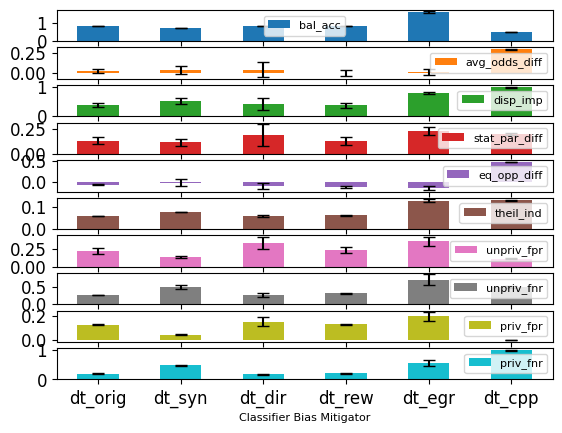

In [ ]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
egr_error_metrics = {k: [statistics.stdev(v)] for (k,v) in egr_metrics.items()}
pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
egr_metrics_mean = {k:[sum(v)/N] for (k,v) in egr_metrics.items()}
pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

if BASELINE == 'lr':
    plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print("5)")
    print(stat)
else:
    plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, egr_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
    stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
    print(stat)

plt.show()

# Visualization

### Fairness

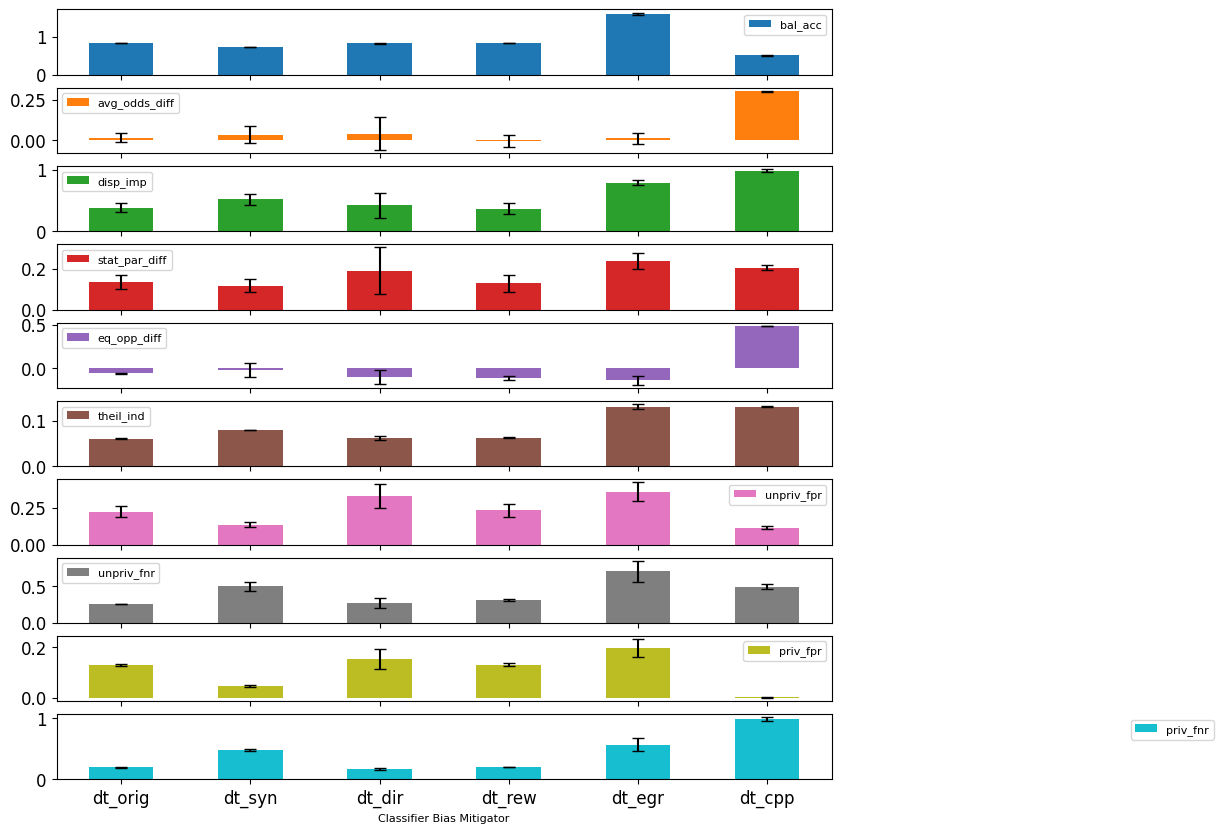

In [ ]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        egr_metrics_mean,
        pr_orig_metrics_mean,
        cpp_metrics_mean,
        ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        egr_error_metrics,
        pr_orig_error_metrics,
        cpp_error_metrics,
        ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn']+ [model_type+'_dir']+ [model_type+'_rew']+ [model_type+'_egr'] + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

In [ ]:
df

,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind,unpriv_fpr,unpriv_fnr,priv_fpr,priv_fnr
Classifier Bias Mitigator,,,,,,,,,,
dt_orig,0.833487,0.017665,0.386655,0.136002,-0.059435,0.060603,0.224490,0.256974,0.129726,0.197540
dt_syn,0.733093,0.034854,0.521621,0.117030,-0.018912,0.079110,0.135083,0.502852,0.046464,0.483940
dt_dir,0.832211,0.040997,0.421155,0.190511,-0.095609,0.061815,0.331390,0.267425,0.153787,0.171817
dt_rew,0.827968,-0.004704,0.369297,0.128080,-0.111352,0.062183,0.233236,0.315269,0.131291,0.203917
dt_egr,1.610893,0.012071,0.794001,0.234449,-0.138713,0.130361,0.360544,0.707375,0.197690,0.568662
dt_cpp,0.519203,0.300967,0.984879,0.205015,0.487963,0.130775,0.115646,0.496249,0.001676,0.984212


## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [ ]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in egr_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_metrics_mean = {k:sum(v)/N for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [ ]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           egr_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,entire_dataset_label_0.0_mia_privacy_risk,entire_dataset_label_1.0_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,,,
orig,0.523736,0.513913,0.595294,0.540373,0.642864,0.513305,0.593908
syn,0.520216,0.512077,0.581444,0.569802,0.661729,0.510778,0.577805
dir,0.531225,0.524572,0.584264,0.582985,0.672629,0.523389,0.580695
rew,0.524906,0.514480,0.604470,0.539876,0.634159,0.514049,0.604307
egr,0.524130,0.513963,0.598402,0.542316,0.642864,0.513318,0.597292


In [ ]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [ ]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [ ]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,0.540373,0.642864,0.513305,0.593908
syn,0.569802,0.661729,0.510778,0.577805
dir,0.582985,0.672629,0.523389,0.580695
rew,0.539876,0.634159,0.514049,0.604307
egr,0.542316,0.642864,0.513318,0.597292


<Axes: xlabel='Classifier MIA Attacks'>

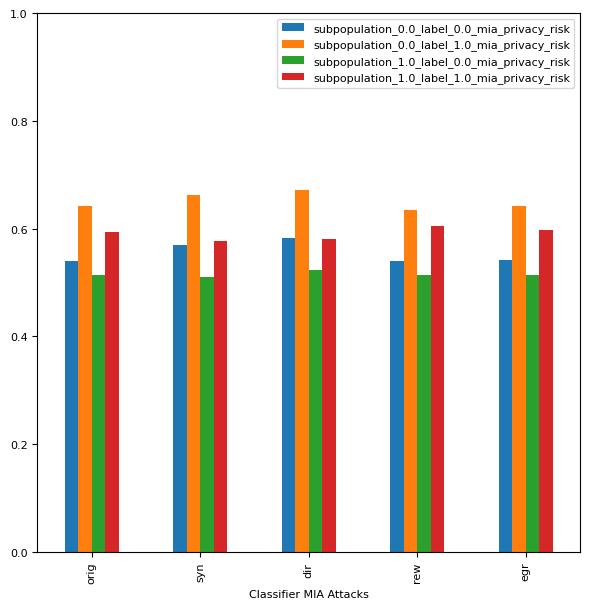

In [ ]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [ ]:
# Tabular Format
# importing the modules
from tabulate import tabulate


# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew       egr
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.540373  0.569802  0.582985  0.539876  0.542316
subpopulation_0.0_label_1.0_mia_privacy_risk  0.642864  0.661729  0.672629  0.634159  0.642864
subpopulation_1.0_label_0.0_mia_privacy_risk  0.513305  0.510778  0.523389  0.514049  0.513318
subpopulation_1.0_label_1.0_mia_privacy_risk  0.593908  0.577805  0.580695  0.604307  0.597292


### Visualizing using novel technique

In [ ]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
egr_mia_error_metrics = {k: v for (k,v) in egr_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.527060
1,orig,entire_dataset_mia_privacy_risk,0.522074
2,orig,entire_dataset_mia_privacy_risk,0.522074
3,orig,entire_dataset_label_0.0_mia_privacy_risk,0.515918
4,orig,entire_dataset_label_0.0_mia_privacy_risk,0.512911
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.512129
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.512129
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.600997
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.595440


In [ ]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.527060
1,orig,entire_dataset_mia_privacy_risk,0.522074
2,orig,entire_dataset_mia_privacy_risk,0.522074
9,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.528901
10,orig,subpopulation_0.0_label_0.0_mia_privacy_risk,0.546109
...,...,...,...
100,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.512129
101,egr,subpopulation_1.0_label_0.0_mia_privacy_risk,0.512129
102,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.600997
103,egr,subpopulation_1.0_label_1.0_mia_privacy_risk,0.595440


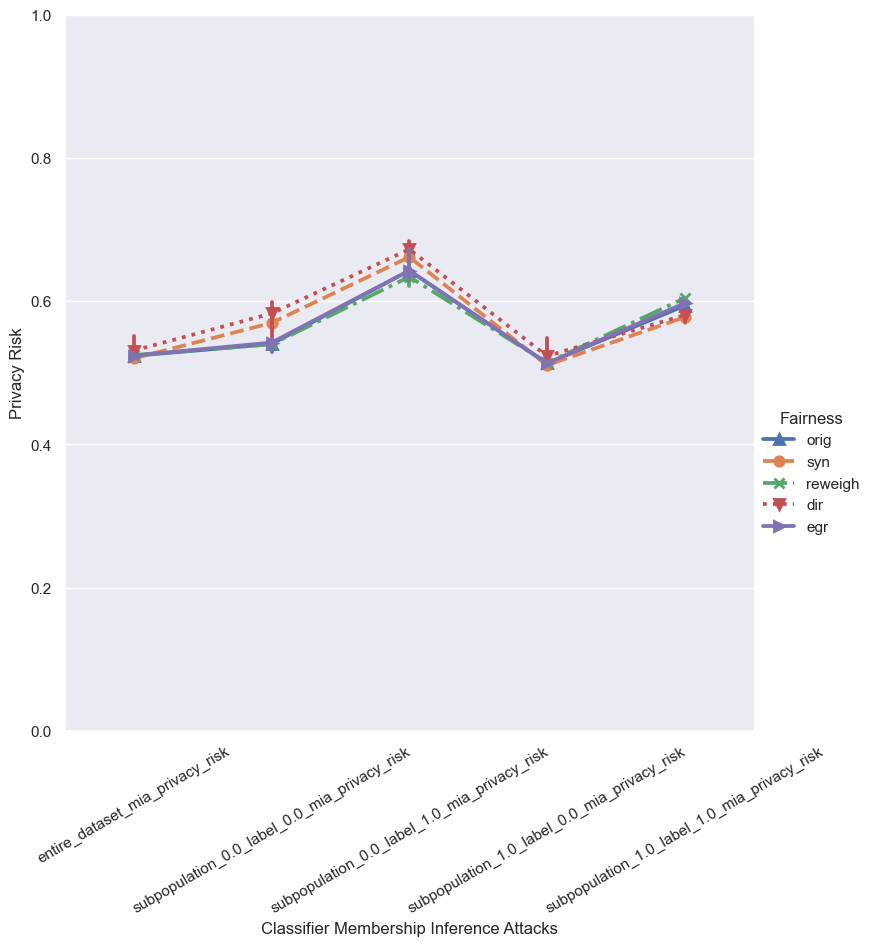

In [ ]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [ ]:
from sklearn.metrics import RocCurveDisplay, auc

In [ ]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

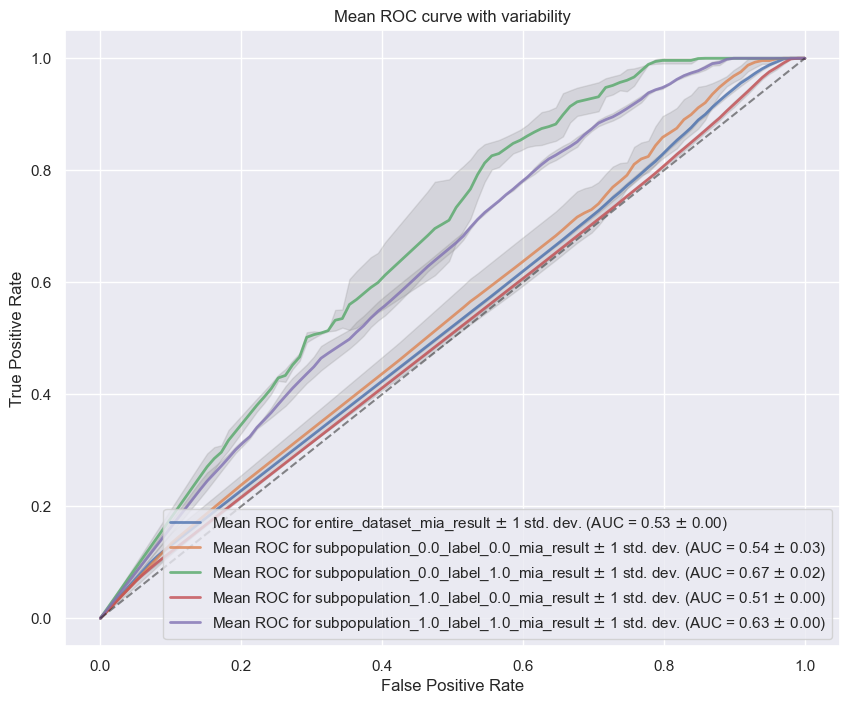

In [ ]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result", "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []

    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)

    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())

    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0

    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

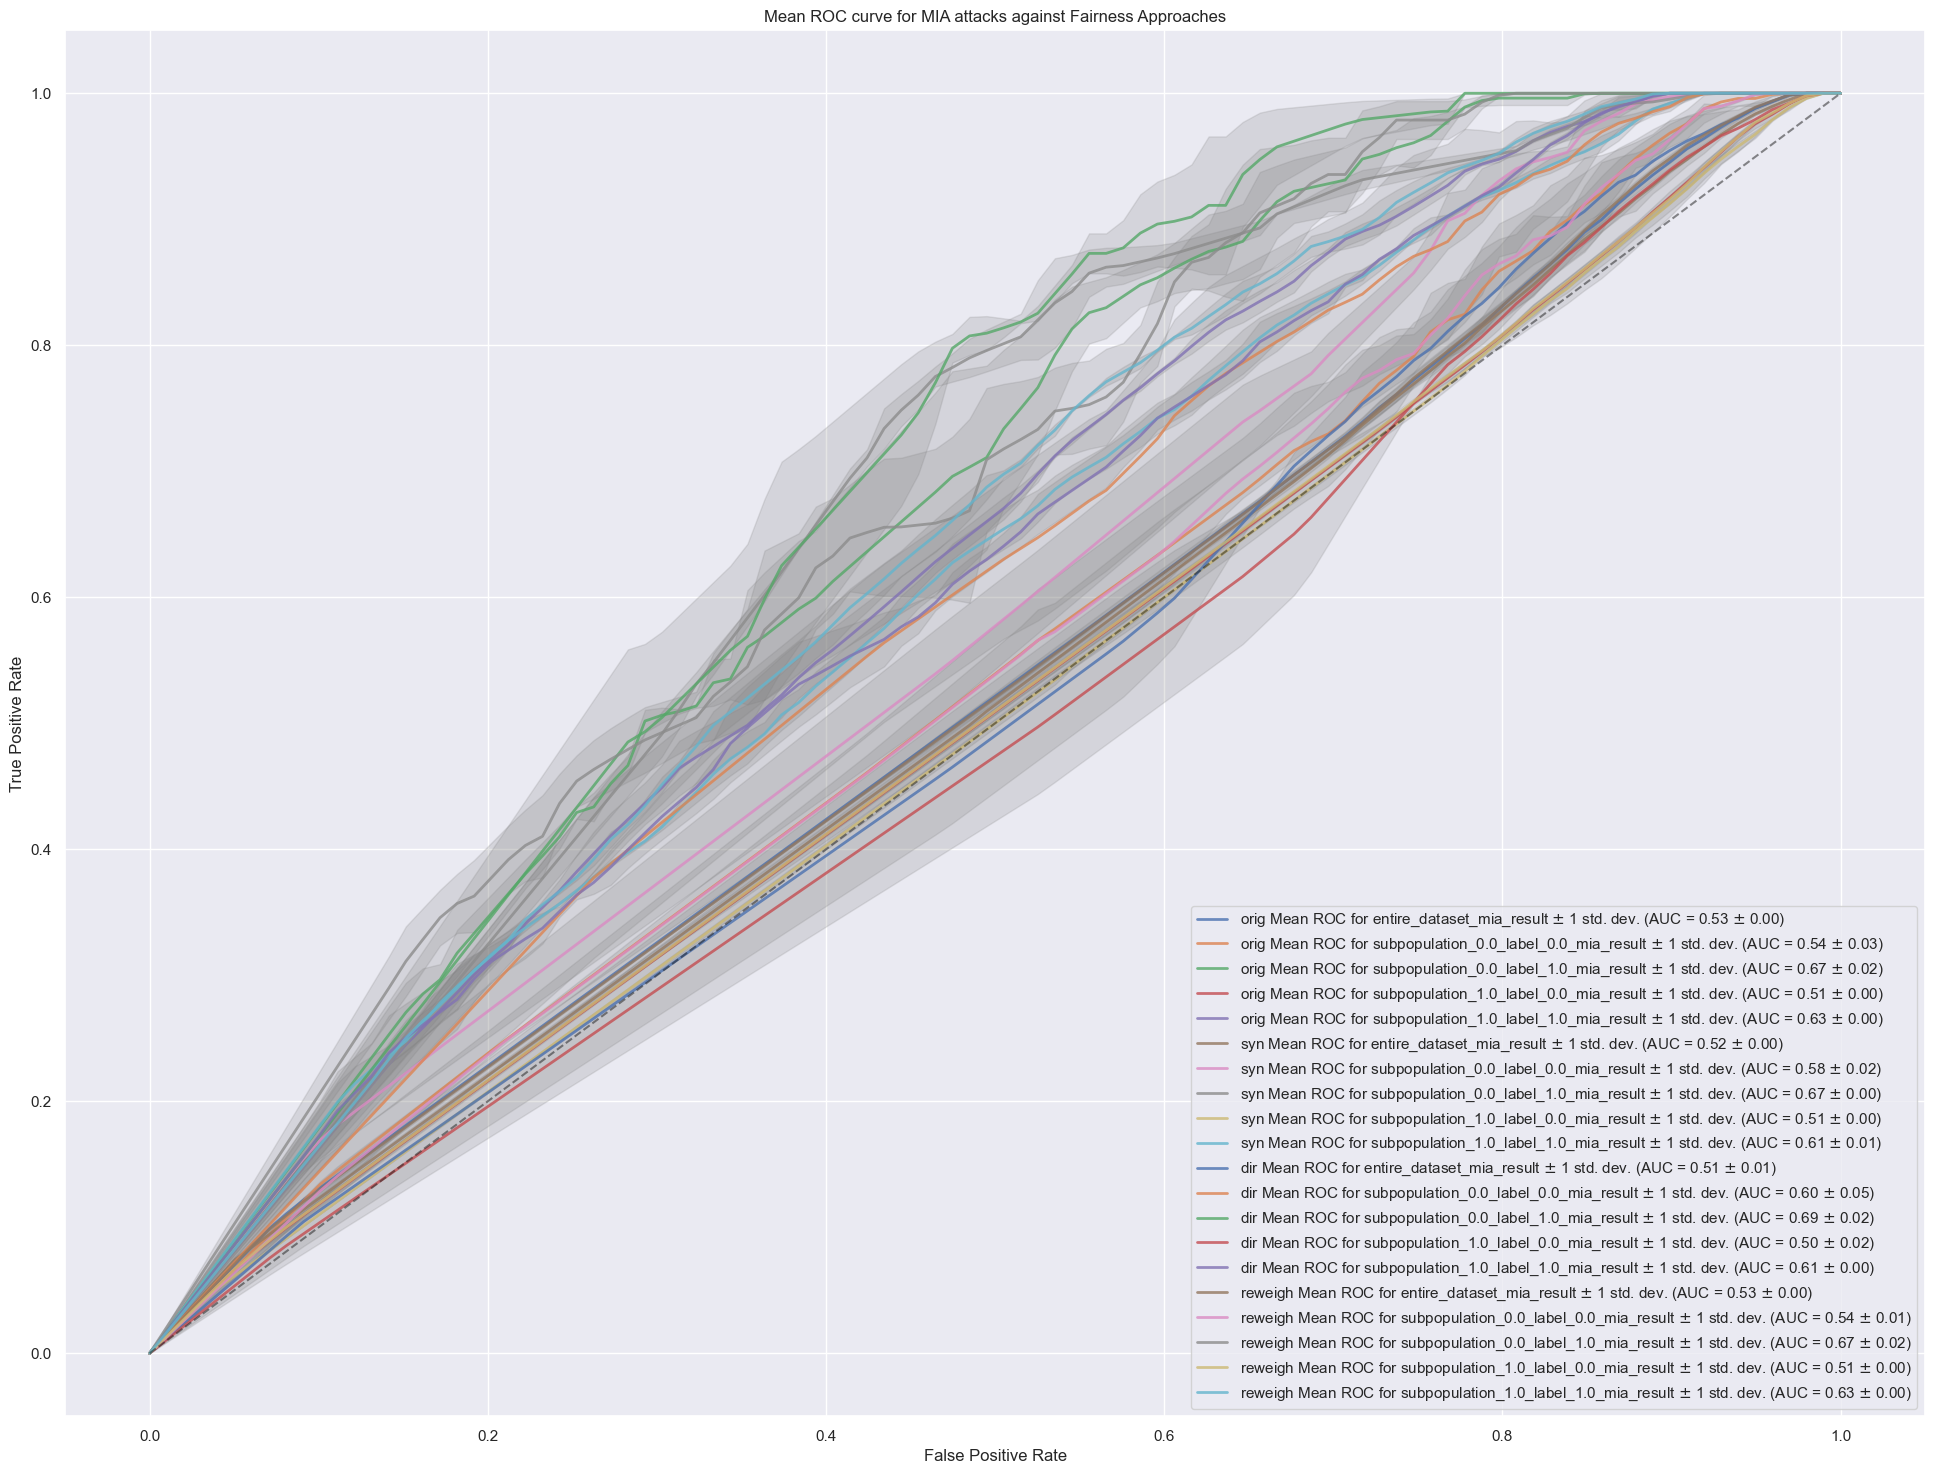

In [ ]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics, dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:

        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

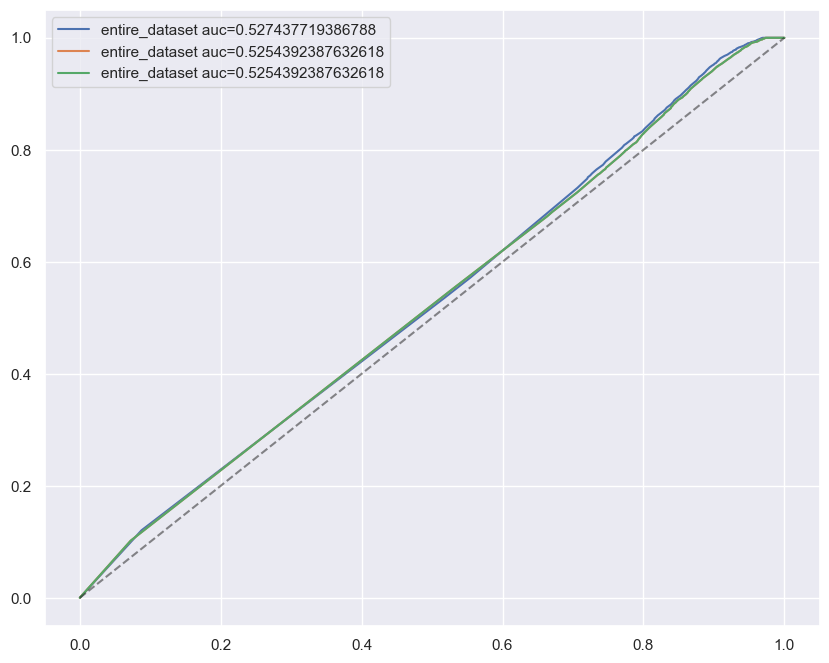

In [ ]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}

In [ ]:
orig_mia_metrics_mean

{'entire_dataset_mia_auc': 0.5261053989711039,
 'entire_dataset_label_0.0_mia_auc': 0.5127795859985386,
 'entire_dataset_label_1.0_mia_auc': 0.6275268170029307,
 'subpopulation_0.0_label_0.0_mia_auc': 0.5393691638145942,
 'subpopulation_0.0_label_1.0_mia_auc': 0.6655555805772776,
 'subpopulation_1.0_label_0.0_mia_auc': 0.5120902557504734,
 'subpopulation_1.0_label_1.0_mia_auc': 0.6256494787374993}

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_auc,entire_dataset_label_0.0_mia_auc,entire_dataset_label_1.0_mia_auc,subpopulation_0.0_label_0.0_mia_auc,subpopulation_0.0_label_1.0_mia_auc,subpopulation_1.0_label_0.0_mia_auc,subpopulation_1.0_label_1.0_mia_auc
Classifier MIA Attacks,,,,,,,
orig,0.526105,0.512780,0.627527,0.539369,0.665556,0.512090,0.625649
syn,0.520466,0.507380,0.615040,0.578153,0.670759,0.505453,0.611072
dir,0.514629,0.499784,0.614493,0.598410,0.686954,0.496654,0.610389
rew,0.525791,0.513382,0.636302,0.540361,0.667536,0.512688,0.634524


<Axes: xlabel='Classifier MIA Attacks'>

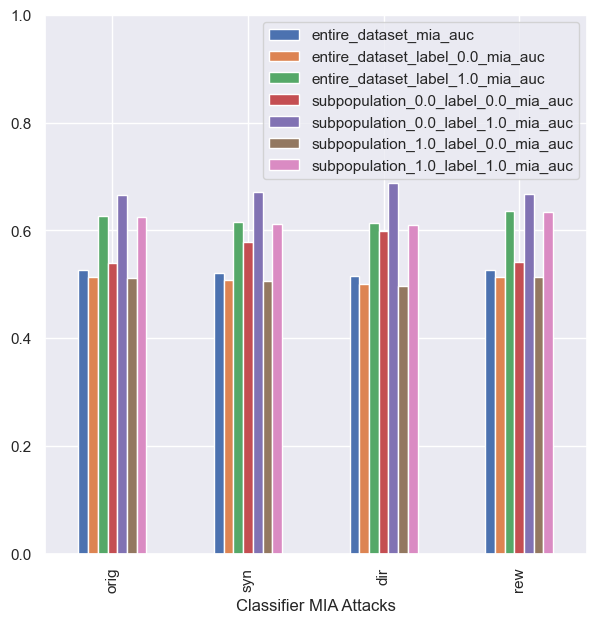

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [ ]:
# Creating data structures to plot point categorical plot from seaborn

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_att_ad

{'entire_dataset_mia_attacker_advantage': [0.05411965363421678,
  0.044148517449488334,
  0.044148517449488334],
 'entire_dataset_label_0.0_mia_attacker_advantage': [0.03183604485047764,
  0.025821590364842772,
  0.025821590364842772],
 'entire_dataset_label_1.0_mia_attacker_advantage': [0.1989163312953074,
  0.1864243139302857,
  0.1864243139302857],
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': [0.057802002788693074,
  0.09221701102801372,
  0.09221701102801372],
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': [0.34492693969952665,
  0.25612968591691987,
  0.25612968591691987],
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': [0.031314697084109056,
  0.02425695461893418,
  0.02425695461893418],
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': [0.19503027971551767,
  0.18420743743375112,
  0.18420743743375112]}

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.05411965363421678],
 ['orig', 'entire_dataset', 0.044148517449488334],
 ['orig', 'entire_dataset', 0.044148517449488334],
 ['orig', 'entire_dataset_label_0.0', 0.03183604485047764],
 ['orig', 'entire_dataset_label_0.0', 0.025821590364842772],
 ['orig', 'entire_dataset_label_0.0', 0.025821590364842772],
 ['orig', 'entire_dataset_label_1.0', 0.1989163312953074],
 ['orig', 'entire_dataset_label_1.0', 0.1864243139302857],
 ['orig', 'entire_dataset_label_1.0', 0.1864243139302857],
 ['orig', 'subpopulation_0.0_label_0.0', 0.057802002788693074],
 ['orig', 'subpopulation_0.0_label_0.0', 0.09221701102801372],
 ['orig', 'subpopulation_0.0_label_0.0', 0.09221701102801372],
 ['orig', 'subpopulation_0.0_label_1.0', 0.34492693969952665],
 ['orig', 'subpopulation_0.0_label_1.0', 0.25612968591691987],
 ['orig', 'subpopulation_0.0_label_1.0', 0.25612968591691987],
 ['orig', 'subpopulation_1.0_label_0.0', 0.031314697084109056],
 ['orig', 'subpopulation_1.0_label_0.0', 0.024

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

,Fairness,MIA,attacker_advantage
0,orig,entire_dataset,0.054120
1,orig,entire_dataset,0.044149
2,orig,entire_dataset,0.044149
3,orig,entire_dataset_label_0.0,0.031836
4,orig,entire_dataset_label_0.0,0.025822
...,...,...,...
79,dir,subpopulation_1.0_label_0.0,0.021749
80,dir,subpopulation_1.0_label_0.0,0.021749
81,dir,subpopulation_1.0_label_1.0,0.141320
82,dir,subpopulation_1.0_label_1.0,0.171424


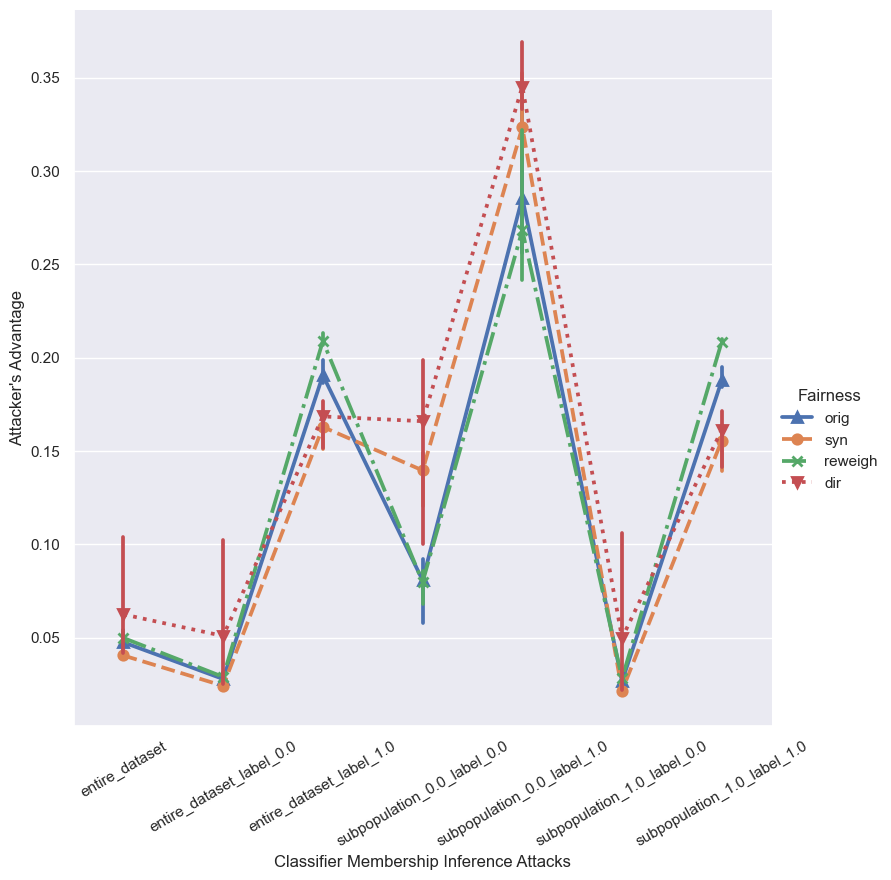

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


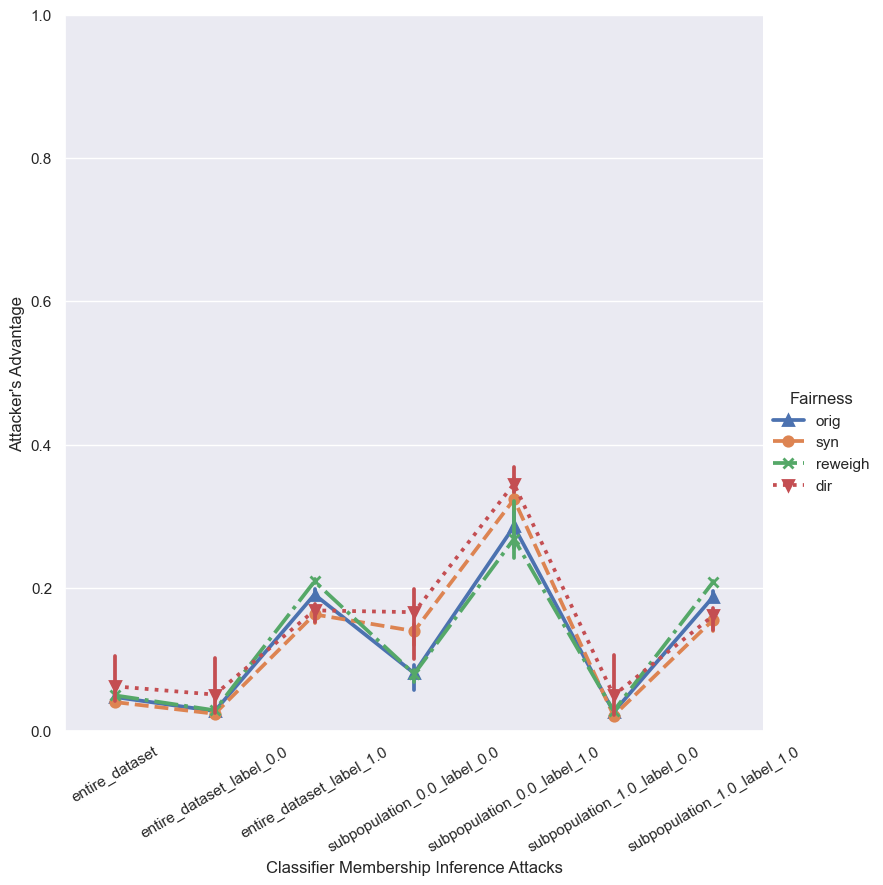

In [ ]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [ ]:
pd.DataFrame(orig_mia_metrics_att_ad)

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
0,0.054120,0.031836,0.198916,0.057802,0.344927,0.031315,0.195030
1,0.044149,0.025822,0.186424,0.092217,0.256130,0.024257,0.184207
2,0.044149,0.025822,0.186424,0.092217,0.256130,0.024257,0.184207


In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}


# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}


In [ ]:
orig_mia_metrics_mean

{'entire_dataset_mia_attacker_advantage': 0.04747222951106448,
 'entire_dataset_label_0.0_mia_attacker_advantage': 0.027826408526721063,
 'entire_dataset_label_1.0_mia_attacker_advantage': 0.19058831971862625,
 'subpopulation_0.0_label_0.0_mia_attacker_advantage': 0.08074534161490683,
 'subpopulation_0.0_label_1.0_mia_attacker_advantage': 0.2857287705111221,
 'subpopulation_1.0_label_0.0_mia_attacker_advantage': 0.026609535440659138,
 'subpopulation_1.0_label_1.0_mia_attacker_advantage': 0.1878150515276733}

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_attacker_advantage,entire_dataset_label_0.0_mia_attacker_advantage,entire_dataset_label_1.0_mia_attacker_advantage,subpopulation_0.0_label_0.0_mia_attacker_advantage,subpopulation_0.0_label_1.0_mia_attacker_advantage,subpopulation_1.0_label_0.0_mia_attacker_advantage,subpopulation_1.0_label_1.0_mia_attacker_advantage
Classifier MIA Attacks,,,,,,,
orig,0.047472,0.027826,0.190588,0.080745,0.285729,0.026610,0.187815
syn,0.040431,0.024155,0.162889,0.139604,0.323459,0.021556,0.155610
dir,0.062451,0.050888,0.168527,0.165969,0.345257,0.049772,0.161389
rew,0.049812,0.028961,0.208940,0.079752,0.268319,0.028097,0.208614


<Axes: xlabel='Classifier MIA Attacks'>

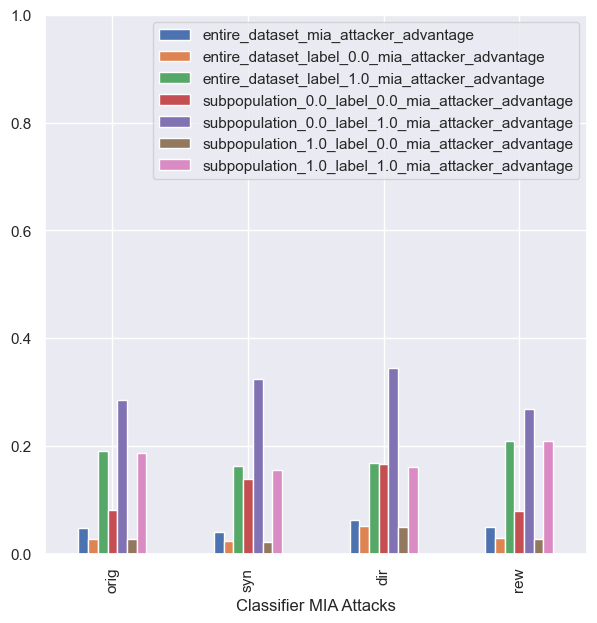

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

[['orig', 'entire_dataset', 0.5790800252047889],
 ['orig', 'entire_dataset', 0.5854025583145223],
 ['orig', 'entire_dataset', 0.5854025583145223],
 ['orig', 'entire_dataset_label_0.0', 0.56359918200409],
 ['orig', 'entire_dataset_label_0.0', 0.5692216280451574],
 ['orig', 'entire_dataset_label_0.0', 0.5692216280451574],
 ['orig', 'entire_dataset_label_1.0', 0.6310013717421125],
 ['orig', 'entire_dataset_label_1.0', 0.6155572176514585],
 ['orig', 'entire_dataset_label_1.0', 0.6155572176514585],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5783132530120483],
 ['orig', 'subpopulation_0.0_label_0.0', 0.5783132530120483],
 ['orig', 'subpopulation_0.0_label_1.0', 0.6046511627906976],
 ['orig', 'subpopulation_0.0_label_1.0', 0.6103896103896105],
 ['orig', 'subpopulation_0.0_label_1.0', 0.6103896103896105],
 ['orig', 'subpopulation_1.0_label_0.0', 0.5674035543996533],
 ['orig', 'subpopulation_1.0_label_0.0', 0.56875],
 ['orig', 'subpopulation_1.0_la

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

,Fairness,MIA,PPV
0,orig,entire_dataset,0.579080
1,orig,entire_dataset,0.585403
2,orig,entire_dataset,0.585403
3,orig,entire_dataset_label_0.0,0.563599
4,orig,entire_dataset_label_0.0,0.569222
...,...,...,...
79,dir,subpopulation_1.0_label_0.0,0.544070
80,dir,subpopulation_1.0_label_0.0,0.544070
81,dir,subpopulation_1.0_label_1.0,0.677994
82,dir,subpopulation_1.0_label_1.0,0.612717


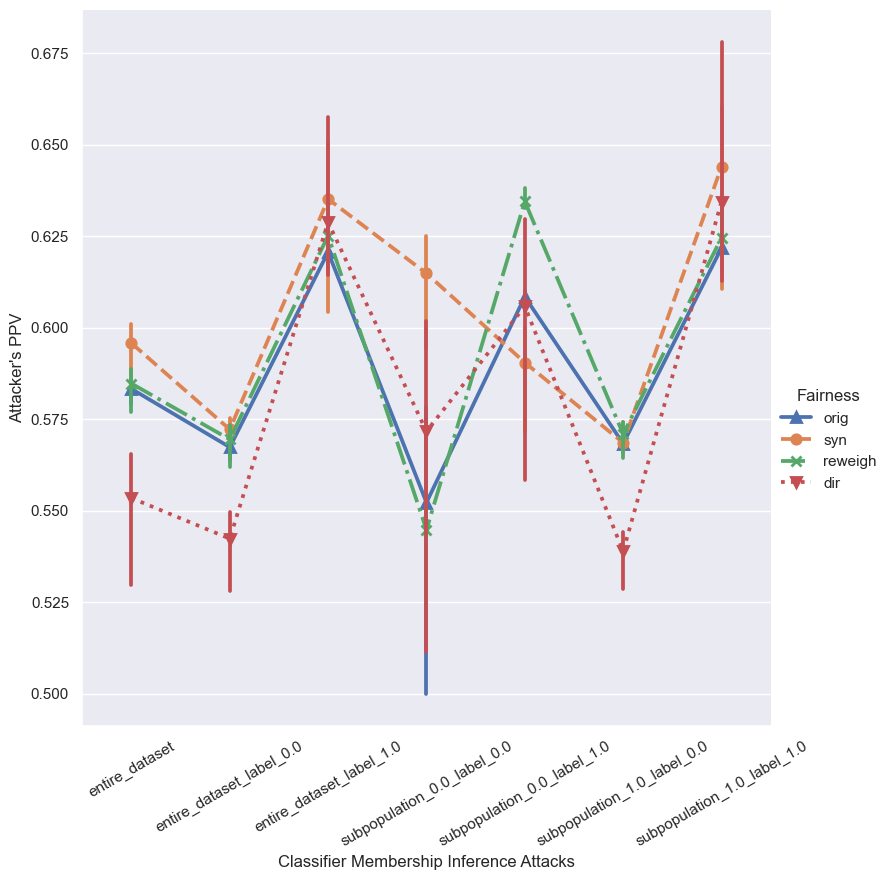

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v"], linestyles=["-", "--", "-.", ":"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [ ]:
import pandas as pd

In [ ]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month=sep,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,poutcome=failure,poutcome=nonexistent,poutcome=success,labels
0,1.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,139.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,1.0,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
30484,1.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30485,1.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30486,1.0,442.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [ ]:
df[["age", "labels"]].value_counts(normalize=True)

age  labels
1.0  0.0       0.851614
1.0  1.0       0.120047
0.0  0.0       0.021812
0.0  1.0       0.006527
Name: proportion, dtype: float64

In [ ]:
df.drop_duplicates()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month=sep,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,day_of_week=wed,poutcome=failure,poutcome=nonexistent,poutcome=success,labels
0,1.0,261.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,226.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,151.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,307.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,139.0,1.0,999.0,0.0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,1.0,334.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
30484,1.0,383.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30485,1.0,189.0,2.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
30486,1.0,442.0,1.0,999.0,0.0,-1.1,94.767,-50.8,1.028,4963.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
